## Imports

In [12]:
import scipy 
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [24]:
skeleton_file_path = glob.glob('data/UTD_MAAD/Skeleton/*.mat')
inertia_file_path = glob.glob('data/UTD_MAAD/Inertial/*.mat')

In [43]:
a = skeleton_file_path[2].split('/')[-1]

In [13]:
b = a.split('_')
c = ('').join(b[:-1])

In [50]:
file_map = {}
for i in range(len(inertia_file_path)):
    identity = inertia_file_path[i].split('/')[-1].split('_')[:-1]
    identity = ('').join(identity)
    file_map[identity] = i


In [51]:
a = skeleton_file_path[2].split('/')[-1]
b = a.split('_')
c = ('').join(b[:-1])

In [53]:
file_map[c]

115

In [23]:
a = kf.split(x)

In [25]:
 next_ind = next(a)

In [31]:
train_index, test_index = next(a)

In [32]:
train_index.shape

(60,)

True
Creating params....
Initiating Model...
ACCELERATION Only Model!
-------------ACCELERATION-------------
Acc Frames:  150
Acc embed dim:  32
Acc depth:  4
-------------Regularization-----------
Drop Rate:  0.0
Attn drop rate:  0.0
Drop path rate:  0.2


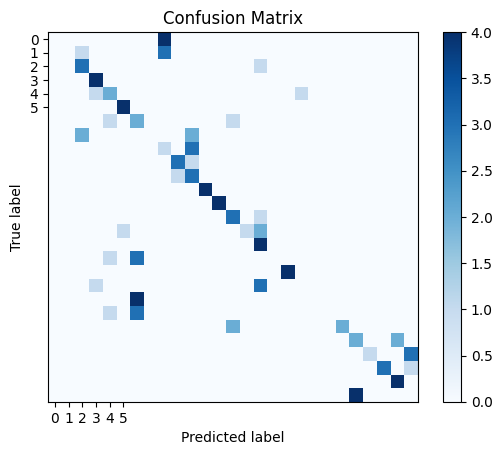

Val accuracy:   50.00 %, Val loss:   0.19777% , Val_teach:  0.00000%


In [7]:
import torch
import numpy as np
import torch.nn.functional as F
from Make_Dataset import Poses3d_Dataset, Utd_Dataset
import torch.nn as nn
import PreProcessing_ncrc
from Models.model_crossview_fusion import ActTransformerMM
from Models.model_acc_only import ActTransformerAcc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True



# Parameters
print("Creating params....")
params = {'batch_size':8,
          'shuffle': True,
          'num_workers': 0}

# Generators
#pose2id,labels,partition = PreProcessing_ncrc_losocv.preprocess_losocv(8)


dataset = 'utd'
mocap_frames = 100
acc_frames = 150
num_joints = 20
num_classes = 27

if dataset == 'ncrc':
    tr_pose2id,tr_labels,valid_pose2id,valid_labels,pose2id,labels,partition = PreProcessing_ncrc.preprocess()
    training_set = Poses3d_Dataset( data='ncrc',list_IDs=partition['train'], labels=tr_labels, pose2id=tr_pose2id, mocap_frames=mocap_frames, acc_frames=acc_frames, normalize=False)
    training_generator = torch.utils.data.DataLoader(training_set, **params) #Each produced sample is  200 x 59 x 3

    validation_set = Poses3d_Dataset(data='ncrc',list_IDs=partition['valid'], labels=valid_labels, pose2id=valid_pose2id, mocap_frames=mocap_frames, acc_frames=acc_frames ,normalize=False)
    validation_generator = torch.utils.data.DataLoader(validation_set, **params) #Each produced sample is 6000 x 229 x 3

    test_set = Poses3d_Dataset(data='ncrc',list_IDs=partition['test'], labels=labels, pose2id=pose2id, mocap_frames=mocap_frames, acc_frames=acc_frames ,normalize=False)
    test_generator = torch.utils.data.DataLoader(test_set, **params) #Each produced sample is 6000 x 229 x 3    
else:

    test_set = Utd_Dataset('/home/bgu9/Fall_Detection_KD_Multimodal/data/UTD_MAAD/valid_data.npz')
    test_generator = torch.utils.data.DataLoader(test_set, **params)


#
#Define model
print("Initiating Model...")

student_model = ActTransformerAcc(device = device, acc_frames=150, num_joints=num_joints, in_chans=3, acc_coords=3,
                                  acc_features=1, has_features=False,num_classes=num_classes)
student_model.load_state_dict(torch.load('/home/bgu9/Fall_Detection_KD_Multimodal/exps/utd/utd_utd_ckpt_wdistance.pt'))
student_model.cuda()

student_model.eval()
y_true = []
y_pred = []
val_loss = 0
val_accuracy = 0
val_t_accuracy = 0
cnt = 0.
student_model=student_model.to(device)
with torch.no_grad():
    for inputs,targets in test_generator:
        y_true.extend(targets.numpy().tolist())
        inputs = inputs.to(device); #print("Validation input: ",inputs)
        targets = targets.to(device)
        
        
        out, student_logits,predictions = student_model(inputs.float())
        loss_score = F.cross_entropy(predictions, targets)
        y_pred.extend(torch.argmax(predictions, 1).cpu().numpy().tolist())
        with torch.no_grad():
            val_loss += loss_score.sum().item()
            val_accuracy += (torch.argmax(predictions, 1) == targets).sum().item()

        cnt += len(targets)
    val_loss /= cnt
    val_accuracy *= 100. / cnt


# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(6))
plt.yticks(np.arange(6))
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()
print(f"Val accuracy:  {val_accuracy:6.2f} %, Val loss:  {val_loss:8.5f}% , Val_teach: {val_t_accuracy:8.5f}%")

### Berkley Mhad Processing

In [21]:
from data.berkley_mhad.labelmap import label_dic

In [24]:
file_paths = glob.glob('data/sensor/Accelerometer/*/*')

In [25]:
total_sample = len(file_paths)
training_samples = round(total_sample*.7)
training_files = file_paths[:training_samples]
val_files = file_paths[training_samples:]

train_dataset = np.zeros((training_samples, 256, 3))
val_dataset = np.zeros((total_sample-training_samples, 256,3))

train_labels = np.zeros((training_samples))
val_labels = np.zeros((total_sample-training_samples))

In [34]:
int(re.findall(pattern, file_paths[1])[0][-2:])

7

In [38]:
label_pattern = r'(a\d+)'
for idx,path in enumerate(file_paths):
    
    #loadding numpy data from csv 
    data = np.genfromtxt(path)
    if np.size(data) == 0 :
        continue
    #taking the accelerometer data
#     print(acc_data.shape)
    acc_data = data[:, :3] 
    act_len = acc_data.shape[0]
    channel = acc_data.shape[1]
    label = int(re.findall(pattern, path)[0][-2:])
    print(label)
    
    #interpolation 
    x = np.linspace(1, 256, num=256)
    xp = np.linspace(1, act_len, num= act_len)
    interpolated_data = np.zeros((256,channel))
    
    for i in range(channel):
        yp = acc_data[:, i]
        axis_interpolated = np.interp(x, xp, yp)
        interpolated_data[:, i] = axis_interpolated
        
    
    if idx < training_samples:
        train_labels[idx] = label
        train_dataset[i, :, :] = interpolated_data
        
    else: 
        val_labels[idx-training_samples] = label
        val_dataset[idx-training_samples, :, :] = interpolated_data
        
        

5
7
4
8
3
1
11
4
2
5
7
9
6
4
3
6
10
5
2
2
10
3
4
11
1
6
2
9
5
7
2
11
1
8
4
7
5
10
10
3
4
6
5
9
2
5
11
3
1
6
4
8
7
5
2
5
7
8
6
4
1
6
3
11
2
9
9
5
6
4
8
4
3
10
7
5
4
8
11
1
2
9
5
7
4
3
6
4
3
10
2
2
10
7
8
3
6
4
5
7
9
2
9
5
1
6
11
8
4
5
7
5
10
3
6
4
2
5
9
7
2
1
4
11
3
8
6
4
5
7
7
10
5
6
4
8
3
3
11
1
2
9
5
11
4
1
6
3
10
4
11
1
6
8
7
5
9
2
10
1
6
11
6
8
7
9
5
10
3
4
8
3
10
7
5
9
7
8
6
11
1
10
5
2
7
5
6
8
4
1
6
3
11
10
5
5
9
7
4
6
8
1
11
2
7
7
10
9
6
8
4
4
8
3
6
9
7
2
11
1
1
4
11
6
9
7
5
2
10
11
3
1
6
8
4
7
5
2
10
7
4
11
1
1
8
11
6
9
5
7
10
9
6
3
3
10
7
5
2
9
6
8
1
11
10
2
7
10
5
4
3
6
8
3
11
8
1
10
7
9
7
10
5
4
6
11
1
2
9
7
8
4
6
6
4
8
7
9
5
2
9
1
6
11
4
6
5
9
7
10
1
4
11
3
2
1
11
3
8
3
4
10
9
7
10
2
11
1
3
6
1
11
4
5
9
9
5
2
4
6
1
3
11
2
5
10
7
9
4
8
3
8
11
1
2
9
5
8
6
8
3
7
10
2
7
5
4
8
11
3
6
1
5
10
9
2
2
10
1
3
11
8
11
4
1
2
5
7
2
10
3
4
6
3
8
5
9
2
9
11
3
6
1
4
8
7
9
7
10
2
1
3
11
4
8
4
6
5
9
9
5
10
6
3
4
11
1
3
2
10
9
2
7
8
4
1
3
11
5
2
5
2
9
6
1
11
8
3
10
2
5
10
7
4
8
1
11
3
2
10
10


5
4
6
8
1
11
2
10
5
7
9
5
6
8
8
3
4
10
7
6
4
8
7
5
2
7
3
4
11
1
4
6
9
5
2
5
10
3
3
10
5
9
6
1
11
4
1
11
3
2
10
5
7
8
3
6
4
3
4
2
10
5
7
9
6
3
4
1
11
2
5
8
4
4
8
7
5
5
9
2
11
6
1
4
6
9
5
7
7
10
2
8
3
8
6
4
2
5
7
5
2
1
3
11
6
4
9
5
10
3
3
4
8
7
10
5
9
4
6
11
3
6
1
2
9
7
5
6
4
8
6
3
2
10
5
9
5
7
4
6
11
4
1
2
7
5
3
8
4
4
8
5
10
7
2
1
11
6
1
4
11
5
7
2
9
10
2
3


In [46]:
#saving data
np.savez('berkley_mhad_train', data = train_dataset, labels = train_labels)
np.savez('berkley_mhad_val', data = val_dataset, labels = val_labels)

### Missing Data Interpolation



In [3]:
dataframe = pd.read_csv('/Users/tousif/Lstm_transformer/Fall_Detection_KD_Multimodal/data/s_aefb_phonewatch/aefbdrink.csv')

### Ploting watch data

In [43]:
x_axis = np.linspace(1, watch_acc.shape[0],num = watch_acc.shape[0])
#interpolation 
interpolated_data = dataframe.iloc[:, 12].interpolate(method = 'linear')
# mean median imputation
mean_value = dataframe.iloc[:,12].mean()
imputed_data = dataframe.iloc[:,12].fillna(mean_value)



### Ploting the Interpolated Values

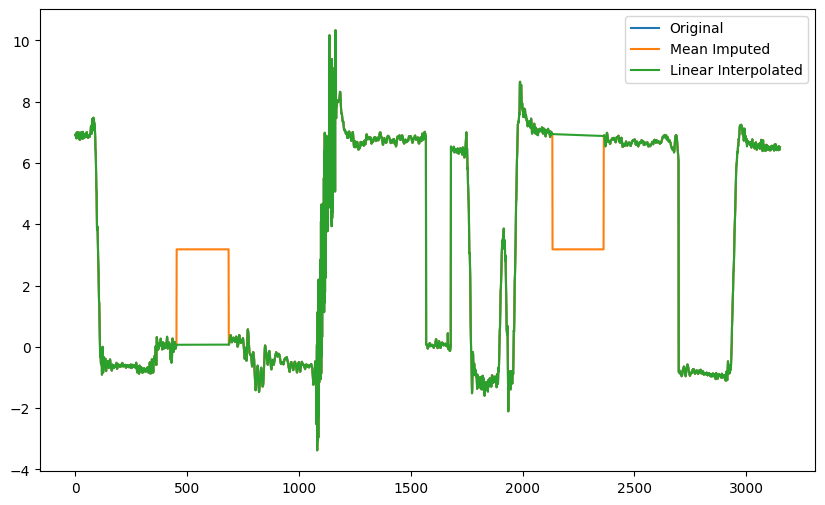

In [46]:

plt.figure(figsize=(10, 6))
plt.plot(x_axis , watch_acc[:, 0], label = 'Original')
plt.plot(x_axis, imputed_data, label = 'Mean Imputed')
plt.plot(x_axis , interpolated_data, label = 'Linear Interpolated')
plt.legend()